In [1]:
# https://drive.google.com/drive/folders/1hNFbb-Ksc9Qdyx0_CB7tTJFy7-UNwYwy?usp=sharing 

# Bildgröße 300x200 RGB

from google.colab import drive
import torchvision 
from torchvision import transforms

from timeit import default_timer as timer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt

from torchsummary import summary

import torch
import torch.nn as nn
from torch.optim import SGD
from torch.utils.data import Dataset, random_split
from torchvision import datasets, transforms


In [2]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [3]:
# Config Feld
path = f"/content/drive/MyDrive/Colab Notebooks/data"
ModelPath = f'/content/drive/MyDrive/Colab Notebooks/models/pythorch.model'
device = "cuda" if torch.cuda.is_available() else "cpu"
TrainingMode = True

valid_size = 0.2
test_size = 0.1

epochs = 50

image_width = 300
image_height = 200

In [4]:
'''dataset = datasets.ImageFolder(('/content/drive/MyDrive/Colab Notebooks/data'),transform = transforms.ToTensor())
loader = torch.utils.data.DataLoader(dataset,
                                     batch_size = 32,
                                     num_workers = 0,
                                     shuffle = False)
mean = 0.0
std = 0.0
for images,_ in loader:
  batch_samples = images.size(0)
  images = images.view(batch_samples,images.size(1),-1)
  mean += images.mean(2).sum(0)
  std += images.std(2).sum(0)

  
mean = mean/len(loader.dataset)
std /= len(loader.dataset)

print(mean)
print(std)'''

"dataset = datasets.ImageFolder(('/content/drive/MyDrive/Colab Notebooks/data'),transform = transforms.ToTensor())\nloader = torch.utils.data.DataLoader(dataset,\n                                     batch_size = 32,\n                                     num_workers = 0,\n                                     shuffle = False)\nmean = 0.0\nstd = 0.0\nfor images,_ in loader:\n  batch_samples = images.size(0)\n  images = images.view(batch_samples,images.size(1),-1)\n  mean += images.mean(2).sum(0)\n  std += images.std(2).sum(0)\n\n  \nmean = mean/len(loader.dataset)\nstd /= len(loader.dataset)\n\nprint(mean)\nprint(std)"

In [5]:
#  transforms.CenterCrop(224),
transform = transforms.Compose([transforms.Resize((image_height, image_width)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.4592, 0.5382, 0.4111),(0.1968, 0.1375, 0.1554))])

dataset = datasets.ImageFolder(path, transform=transform)

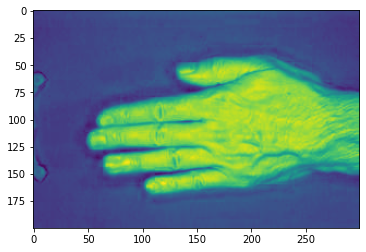

In [6]:
dataset[0][0][2]
plt.imshow(dataset[0][0][0])
plt.show()

In [7]:
# https://discuss.pytorch.org/t/how-to-use-imagefolder-with-list-of-images-for-train-and-test-sets/120247
# trainset = torch.utils.data.Subset(dataset_train, train_indices)
# valset = torch.utils.data.Subset(dataset_val, val_indices)
def get_data(): 
  n_val = int(np.floor(valid_size * len(dataset)))
  n_test = int(np.floor(test_size * len(dataset)))
  n_train = len(dataset) - n_val - n_test

  train_ds, val_ds, test_ds = random_split(dataset, [n_train, n_val, n_test])
  train_dl = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)

  valid_dl = torch.utils.data.DataLoader(val_ds, batch_size=32, shuffle=True)
  test_dl = torch.utils.data.DataLoader(test_ds, batch_size=32, shuffle=True)
  return train_dl, test_dl, valid_dl

In [8]:
@torch.no_grad()
def accuracy(x, y, model):
    with torch.no_grad():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [9]:
@torch.no_grad()
def loss(x, y, model):
    prediction = model(x)
    loss = loss_fn(prediction, y)
    return loss.item()

In [10]:
'''
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2) # halbiert um 2
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2) # halbiert um 2
        self.fc1 = nn.Linear(8 * int((image_width/2)/2) * int((image_height/2)/2), 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 4)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * int((image_width/2)/2) * int((image_height/2)/2)) # <1>
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out
        #'''

'\nclass Net(nn.Module):\n    def __init__(self):\n        super().__init__()\n        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)\n        self.act1 = nn.Tanh()\n        self.pool1 = nn.MaxPool2d(2) # halbiert um 2\n        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)\n        self.act2 = nn.Tanh()\n        self.pool2 = nn.MaxPool2d(2) # halbiert um 2\n        self.fc1 = nn.Linear(8 * int((image_width/2)/2) * int((image_height/2)/2), 32)\n        self.act3 = nn.Tanh()\n        self.fc2 = nn.Linear(32, 4)\n\n    def forward(self, x):\n        out = self.pool1(self.act1(self.conv1(x)))\n        out = self.pool2(self.act2(self.conv2(out)))\n        out = out.view(-1, 8 * int((image_width/2)/2) * int((image_height/2)/2)) # <1>\n        out = self.act3(self.fc1(out))\n        out = self.fc2(out)\n        return out\n        #'

In [11]:

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(96, 256, kernel_size=5, padding=2)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(256, 384, kernel_size=3, padding=1)
        self.act3 = nn.ReLU()
        self.conv4 = nn.Conv2d(384, 384, kernel_size=3, padding=1)
        self.act4 = nn.ReLU()
        self.conv5 = nn.Conv2d(384, 256, kernel_size=3, padding=1)
        self.act5 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.fc1 = nn.Linear(10240, 4096)
        self.act6 = nn.ReLU()
        self.fc2 = nn.Linear(4096, 4096)
        self.act7 = nn.ReLU()
        self.fc3 = nn.Linear(4096, 4)
        self.softmax = nn.Softmax(1)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = self.act3(self.conv3(out))
        out = self.act4(self.conv4(out))
        out = self.pool3(self.act5(self.conv5(out)))
        out = out.view(-1,10240) # <1>
        out = self.act6(self.fc1(out))
        out = self.act7(self.fc2(out))
        out = self.fc3(out)
        out = self.softmax(out)
        return out
        
#'''

In [12]:
def get_model():
    model = Net().to(device)
    loss_fn = nn.CrossEntropyLoss()  # Kreuzentropie
    optimizer = SGD(model.parameters(), lr=1e-1)
    return model, loss_fn, optimizer

In [13]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [14]:
def is_early_stopping(val_accuracies, amount_epoch, threshold=0.01):

  # Wenn man mindestens <amount_epoch> vergleichen möchte aber noch nicht 
  # so viele epochen durchlaufen hat, kann noch kein Early Stopping stattfinden
  if len(val_accuracies) < amount_epoch: 
    return False

  # nur die letzten <amount_epoch> Elemente übernehmen
  epochs = val_accuracies[-amount_epoch:]

  # Betragliche differenz zwischen den Werten für index i und i+1 bilden
  abs_differences  = []
  for i in range(0 , len(epochs) -1):
    abs_differences.append(abs(epochs[i] - epochs[i + 1]))
    
  # Wenn alle Differenzen in der Liste kleiner sind als der Schwellwert ist Early Stopping!
  return all(x < threshold for x in abs_differences)


In [15]:
# Test Early stopping
assert is_early_stopping([0.1, 0.2], 4, 0.11) == False, "Sollte False sein, da len(val_accuracies) kleiner ist als die mindestens erfoderlichen 4 epochen zum prüfen der differenz"
assert is_early_stopping([0.1, 0.2, 0.3, 0.4], 4, 0.1) == False, "Sollte False sein, da 0.1 < 0.1 false ist"
assert is_early_stopping([0.1, 0.1, 0.2, 0.3], 4, 0.11) == True, "Sollte True sein, da 0.1 < 0.11 True ist"
assert is_early_stopping([0.1, 0.2, 0.3, 0.5, 0.7, 0.9], 4, 0.11) == False, "Sollte False sein, da die letzten drei Größere differenzen haben als 0.11"
# Aus Trainingsbeispiel
assert is_early_stopping([96.15, 100.0, 96.15, 96.15, 96.15, 96.15, 84.62], 5, 1) == False, "Sollte False sein weil der Letzte wert nicht passt"

In [16]:
model, loss_fn, optimizer = get_model()

In [17]:
# 3 - R, G, B 
# 224 - Width 
# 224 - Height
#summary(Net(), (3, 300, 200))
# Output Shape
# [-1, 16, 224, 224] 
# First Index: Batch-Size (-1 means it doesn't matter)

In [18]:
train_dl, test_dl, val_dl = get_data()

In [ ]:
print('Starting training...')

time0 = timer()



arrPlotX = []
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
epoch_time = []

if TrainingMode:
    for epoch in range(epochs):
        time1 = timer()
        train_epoch_losses, train_epoch_accuracies = [], []

        for ix, batch in enumerate(iter(train_dl)):
            x, y = batch
            
            batch_loss = train_batch(x, y, model, optimizer, loss_fn)  # Mini-Batch
            train_epoch_losses.append(batch_loss)
        train_epoch_loss = np.array(train_epoch_losses).mean()

        for ix, batch in enumerate(iter(train_dl)):
            x, y = batch
            is_correct = accuracy(x, y, model)
            train_epoch_accuracies.extend(is_correct)
        train_epoch_accuracy = np.mean(train_epoch_accuracies)

        val_is_correct = None
        validation_loss = None

        for ix, batch in enumerate(iter(val_dl)):
            x, y = batch
            val_is_correct = accuracy(x, y, model)
            validation_loss = loss(x, y, model)

        val_epoch_accuracy = np.mean(val_is_correct)
        arrPlotX.append(epoch)
        train_losses.append(train_epoch_loss)
        train_accuracies.append(train_epoch_accuracy)
        val_losses.append(validation_loss)
        val_accuracies.append(val_epoch_accuracy)

        time2 = timer() - time1
        epoch_time.append(time2)
        print(f"epoch: {epoch}  train_acc: {100 * train_epoch_accuracy:.2f}%  val_acc: {100 * val_epoch_accuracy:.2f}%  time: {time2}s")
        # Early stopping
        if is_early_stopping(val_accuracies, 5, 0.01):
            print(f'Early Stopping...')
            break

        

   # torch.save(model.state_dict(), ModelPath)

    plt.plot(arrPlotX, train_accuracies)
    plt.plot(arrPlotX, val_accuracies)
    plt.savefig("accuracies.png")
else:
    val_is_correct = None
    for ix, batch in enumerate(iter(test_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = loss(x, y, model)

    for ix, var in enumerate(iter(val_is_correct)):
        if var is False:
            print(test_dl.dataset.__getitem__(ix))
    val_epoch_accuracy = np.mean(val_is_correct)
    print(f"test_acc: {100 * val_epoch_accuracy:.2f}%")


Starting training...
epoch: 0  train_acc: 32.06%  val_acc: 32.00%  time: 1653.8301525650002s
epoch: 1  train_acc: 47.70%  val_acc: 44.00%  time: 502.78939960699995s
epoch: 2  train_acc: 62.13%  val_acc: 64.00%  time: 507.374833629s
epoch: 3  train_acc: 64.31%  val_acc: 56.00%  time: 500.79833370000006s
epoch: 4  train_acc: 71.60%  val_acc: 56.00%  time: 500.819037406s
epoch: 5  train_acc: 74.56%  val_acc: 80.00%  time: 503.23231246000023s
epoch: 6  train_acc: 66.33%  val_acc: 52.00%  time: 500.1277833280001s
epoch: 7  train_acc: 77.10%  val_acc: 76.00%  time: 500.35383976899993s
epoch: 8  train_acc: 79.51%  val_acc: 60.00%  time: 501.1703096729998s
epoch: 9  train_acc: 81.02%  val_acc: 60.00%  time: 503.7784219619998s
epoch: 10  train_acc: 83.52%  val_acc: 84.00%  time: 500.44785822499944s
epoch: 11  train_acc: 76.77%  val_acc: 60.00%  time: 501.0394723240006s
epoch: 12  train_acc: 60.13%  val_acc: 56.00%  time: 502.3506264810003s
epoch: 13  train_acc: 67.36%  val_acc: 72.00%  time: 50

In [ ]:
val_is_correct = None
for ix, batch in enumerate(iter(test_dl)):
    x, y = batch
    val_is_correct = accuracy(x, y, model)
    validation_loss = loss(x, y, model)

for ix, var in enumerate(iter(val_is_correct)):
    if var is False:
        print(test_dl.dataset.__getitem__(ix))
val_epoch_accuracy = np.mean(val_is_correct)
print(f"test_acc: {100 * val_epoch_accuracy:.2f}%")